In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

In [2]:
df = pd.read_csv('wfp_food_prices_ind.csv')
df = df[df['admin1']=='Karnataka']
df = df[df['commodity']=='Wheat']
df.head()

C:\Users\kshit\AppData\Local\Temp\ipykernel_19196\3079750901.py:1: DtypeWarning: Columns (4,5,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wfp_food_prices_ind.csv')


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
10,1994-01-15,Karnataka,Bangalore Urban,Bengaluru,12.962299,77.576943,cereals and tubers,Wheat,KG,actual,Retail,INR,7.0,0.2231
75,1994-03-15,Karnataka,Bangalore Urban,Bengaluru,12.962299,77.576943,cereals and tubers,Wheat,KG,actual,Retail,INR,6.5,0.2073
118,1994-04-15,Karnataka,Bangalore Urban,Bengaluru,12.962299,77.576943,cereals and tubers,Wheat,KG,actual,Retail,INR,6.5,0.2073
155,1994-05-15,Karnataka,Bangalore Urban,Bengaluru,12.962299,77.576943,cereals and tubers,Wheat,KG,actual,Retail,INR,4.0,0.1275
214,1994-07-15,Karnataka,Bangalore Urban,Bengaluru,12.962299,77.576943,cereals and tubers,Wheat,KG,actual,Retail,INR,6.8,0.2168


In [3]:
df.drop(columns=['latitude','longitude','priceflag','currency','category','commodity','unit','pricetype'],inplace=True)
df.head()

,date,admin1,admin2,market,price,usdprice
10,1994-01-15,Karnataka,Bangalore Urban,Bengaluru,7.0,0.2231
75,1994-03-15,Karnataka,Bangalore Urban,Bengaluru,6.5,0.2073
118,1994-04-15,Karnataka,Bangalore Urban,Bengaluru,6.5,0.2073
155,1994-05-15,Karnataka,Bangalore Urban,Bengaluru,4.0,0.1275
214,1994-07-15,Karnataka,Bangalore Urban,Bengaluru,6.8,0.2168


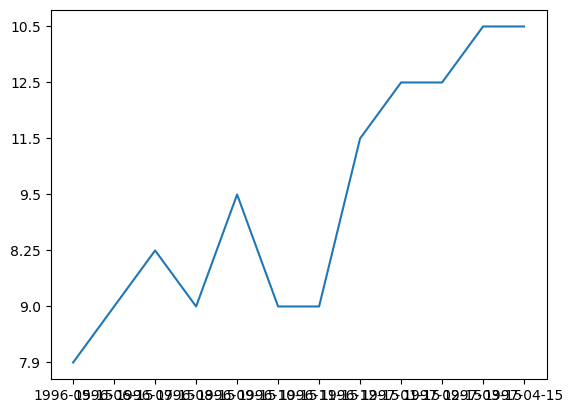

In [4]:
plt.plot(df['date'][13:25],df['price'][13:25])


In [5]:
df.shape

(694, 6)

In [6]:
pd.to_numeric(df['price'])

10         7.00
75         6.50
118        6.50
155        4.00
214        6.80
          ...  
172761    44.45
172843    44.33
172924    44.36
173088    44.28
173175    44.15
Name: price, Length: 694, dtype: float64

In [7]:
data = df['price'].values

# Define the split percentages
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)
test_size = len(data) - train_size - val_size

# Split the data
train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

print(f"Train data: {len(train_data)} months")
print(f"Validation data: {len(val_data)} months")
print(f"Test data: {len(test_data)} months")

Train data: 555 months
Validation data: 69 months
Test data: 70 months


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a MinMaxScaler to scale the price data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape data into a 2D array for the scaler
price_scaled = scaler.fit_transform(df['price'].values.reshape(-1, 1))

# Convert back to a 1D array
price_scaled = price_scaled.flatten()

In [9]:
def create_dataset(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# For example, if you use the past 12 months to predict the next month's price:
window_size = 12
X, y = create_dataset(price_scaled, window_size=window_size)

In [10]:
X_dense = X

# Reshaping for LSTM or Conv1D layers (add an extra dimension for features)
X_lstm = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:
# Using the splits you calculated earlier
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]


In [12]:
# Example function to create sliding windows
def create_windowed_dataset(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])  # Past 'window_size' values as input
        y.append(data[i + window_size])    # Next value as the target output
    return np.array(X), np.array(y)

# Assuming 'price_scaled' is your preprocessed and scaled time series data
window_size = 12  # Using 12 months (1 year) of data to predict the next month
X, y = create_windowed_dataset(price_scaled, window_size)

# Check the shape of the inputs and outputs
print(f"Input shape (X): {X.shape}")  # Expected: (num_samples, window_size)
print(f"Output shape (y): {y.shape}")

Input shape (X): (682, 12)
Output shape (y): (682,)


In [13]:
X_lstm = X.reshape((X.shape[0], X.shape[1], 1)) 

In [14]:
# Define the Dense model architecture
def build_dense_model(window_size):
    model = tf.keras.Sequential()
    
    # Input layer (takes input of shape `window_size`)
    model.add(layers.InputLayer(input_shape=(window_size,)))
    
    # First hidden layer with 64 neurons and ReLU activation
    model.add(layers.Dense(64, activation='relu'))
    
    # Second hidden layer with 64 neurons and ReLU activation
    model.add(layers.Dense(64, activation='relu'))

    # Third hidden layer with 64 neurons and ReLU activation
    model.add(layers.Dense(64, activation='relu'))

    # Fourth hidden layer with 64 neurons and ReLU activation
    model.add(layers.Dense(64, activation='relu'))
    
    # Output layer (single neuron, no activation for regression)
    model.add(layers.Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Example: assuming window_size is 12
window_size = 12
dense_model = build_dense_model(window_size)

# Summary of the model architecture
dense_model.summary()


c:\Users\kshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,377 (52.25 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2633 - mae: 0.4442 - val_loss: 0.0072 - val_mae: 0.0737
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - mae: 0.1120 - val_loss: 0.0252 - val_mae: 0.1459
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - mae: 0.0685 - val_loss: 0.0050 - val_mae: 0.0523
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - mae: 0.0552 - val_loss: 0.0038 - val_mae: 0.0434
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mae: 0.0460 - val_loss: 0.0038 - val_mae: 0.0435
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.0436 - val_loss: 0.0038 - val_mae: 0.0430
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0393 - val_loss: 0.0039 - val_mae: 0.0437
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mae: 0.0399 - val_loss: 0.0038 - val_mae: 0.0427
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.002

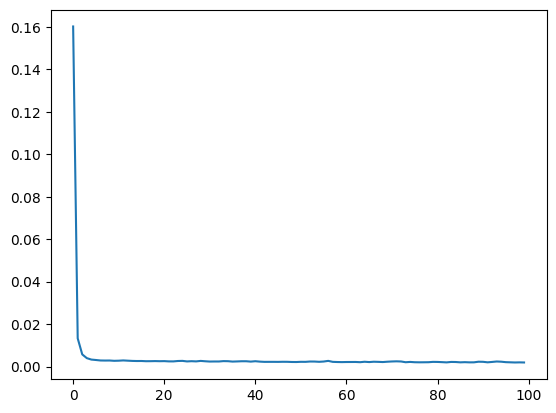

In [15]:
# Assuming X_train and y_train are the preprocessed input and output data
history = dense_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_mae = dense_model.evaluate(X_test, y_test)

print(f"Test MAE: {test_mae}")

plt.plot(history.history['loss'], label='train')

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the LSTM model architecture
def build_lstm_model(window_size):
    model = tf.keras.Sequential()
    
    # LSTM layer with 50 units (neurons)
    model.add(layers.LSTM(50, activation='relu', input_shape=(window_size, 1)))
    
    # Optionally, you can add more LSTM layers here
    # model.add(layers.LSTM(50, activation='relu', return_sequences=False))

    # Dense output layer (1 neuron for predicting the next time step's value)
    model.add(layers.Dense(1))
    
    # Compile the model with Adam optimizer and MSE loss function
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Example: Assuming window_size is 12 (12 months), input shape will be (12, 1)
window_size = 12
lstm_model = build_lstm_model(window_size)

# Summary of the model
lstm_model.summary()


c:\Users\kshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2728 - mae: 0.4693 - val_loss: 0.2993 - val_mae: 0.5430
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0871 - mae: 0.2480 - val_loss: 0.0064 - val_mae: 0.0687
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 - mae: 0.0931 - val_loss: 0.0135 - val_mae: 0.1022
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - mae: 0.0660 - val_loss: 0.0034 - val_mae: 0.0392
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - mae: 0.0580 - val_loss: 0.0035 - val_mae: 0.0399
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0501 - val_loss: 0.0035 - val_mae: 0.0400
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - mae: 0.0477 - val_loss: 0.0043 - val_mae: 0.0491
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mae: 0.0442 - val_loss: 0.0043 - val_mae: 0.0488
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.00

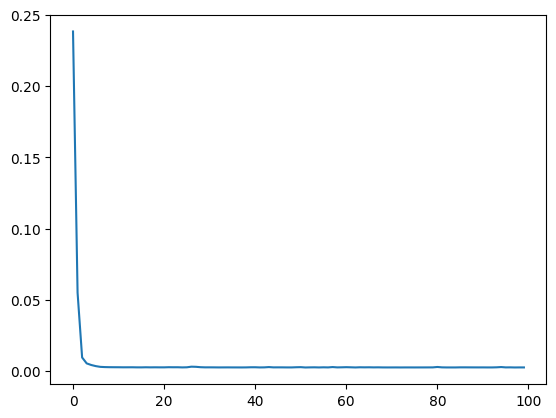

In [17]:
# Assuming X_train and y_train are preprocessed and windowed for LSTM input
history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_mae = lstm_model.evaluate(X_test, y_test)

print(f"Test MAE: {test_mae}")

plt.plot(history.history['loss'], label='train')

In [18]:
# Reshape X_train, X_val, and X_test for LSTM input
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [19]:
# Define the Conv1D model architecture
def build_conv1d_model(window_size):
    model = tf.keras.Sequential()
    
    # Conv1D layer with 64 filters, kernel size of 2, and ReLU activation
    model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
    
    # MaxPooling1D layer to reduce dimensionality (optional)
    model.add(layers.MaxPooling1D(pool_size=2))
    
    # Flatten the output before feeding into Dense layers
    model.add(layers.Flatten())
    
    # Dense hidden layer with 50 units and ReLU activation
    model.add(layers.Dense(50, activation='relu'))
    
    # Output layer (1 neuron for predicting the next time step's value)
    model.add(layers.Dense(1))
    
    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

# Example: Assuming window_size is 12 (12 months)
window_size = 12
conv1d_model = build_conv1d_model(window_size)

# Summary of the model
conv1d_model.summary()

c:\Users\kshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │        16,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,293 (63.64 KB)

 Trainable params: 16,293 (63.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1969 - mae: 0.3804 - val_loss: 0.0054 - val_mae: 0.0558
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - mae: 0.0852 - val_loss: 0.0069 - val_mae: 0.0654
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - mae: 0.0572 - val_loss: 0.0071 - val_mae: 0.0668
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - mae: 0.0479 - val_loss: 0.0038 - val_mae: 0.0441
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 0.0040 - val_mae: 0.0456
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0432 - val_loss: 0.0038 - val_mae: 0.0443
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mae: 0.0385 - val_loss: 0.0036 - val_mae: 0.0430
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mae: 0.0412 - val_loss: 0.0047 - val_mae: 0.0506
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.002

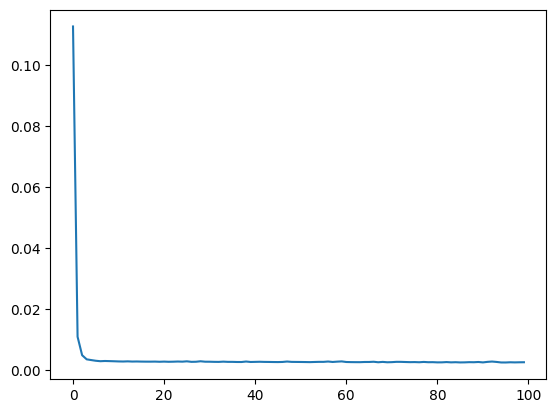

In [20]:
# Assuming X_train and y_train are preprocessed and windowed for Conv1D input
history = conv1d_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_mae = conv1d_model.evaluate(X_test, y_test)

print(f"Test MAE: {test_mae}")

plt.plot(history.history['loss'], label='train')

In [21]:
# Reshape X_train, X_val, and X_test for Conv1D input
X_train_conv1d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_conv1d = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_conv1d = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [27]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Assuming y_test and y_pred are available for each model
# Example for Dense model
y_pred_dense = dense_model.predict(X_test)
mae_dense, mse_dense, rmse_dense = calculate_metrics(y_test, y_pred_dense)

# Example for LSTM model
y_pred_lstm = lstm_model.predict(X_test)
mae_lstm, mse_lstm, rmse_lstm = calculate_metrics(y_test, y_pred_lstm)

# Example for Conv1D model
y_pred_conv1d = conv1d_model.predict(X_test)
mae_conv1d, mse_conv1d, rmse_conv1d = calculate_metrics(y_test, y_pred_conv1d)

# Print or store the results for comparison
print(f"Dense Model - MAE: {mae_dense}, MSE: {mse_dense}, RMSE: {rmse_dense}")
print(f"LSTM Model - MAE: {mae_lstm}, MSE: {mse_lstm}, RMSE: {rmse_lstm}")
print(f"Conv1D Model - MAE: {mae_conv1d}, MSE: {mse_conv1d}, RMSE: {rmse_conv1d}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
Dense Model - MAE: 0.04898437463704821, MSE: 0.003740040959809964, RMSE: 0.06115587428702139
LSTM Model - MAE: 0.04495313917532924, MSE: 0.0033202330449325877, RMSE: 0.05762146340498988
Conv1D Model - MAE: 0.06234000965765894, MSE: 0.00538999988217152, RMSE: 0.07341661856944598


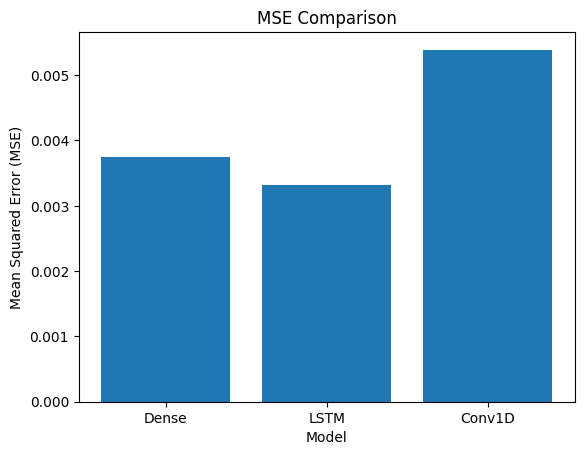

In [23]:
import matplotlib.pyplot as plt

# Assuming you have MSE values for different models


models = ['Dense', 'LSTM', 'Conv1D']
mse_values = [mse_dense, mse_lstm, mse_conv1d]

plt.bar(models, mse_values)
plt.title('MSE Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()


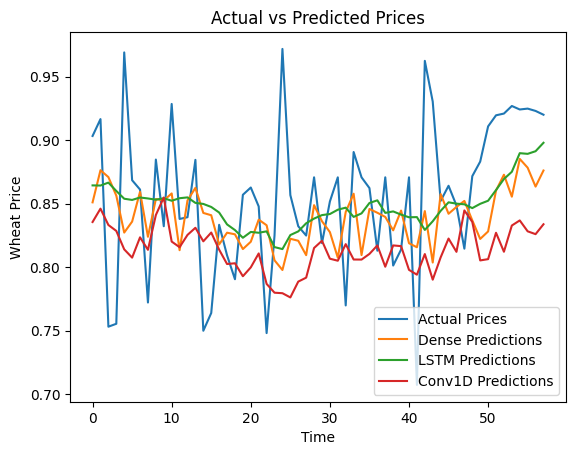

In [24]:
# Assuming you have actual and predicted values for different models


# Time points for plotting (months)
time_points = np.arange(0, len(y_test))

# # Replace with actual predictions from each model
# y_test = []  # Actual values
# y_pred_dense = []  # Predictions from Dense model
# y_pred_lstm = []  # Predictions from LSTM model
# y_pred_conv1d = []  # Predictions from Conv1D model

plt.plot(time_points, y_test, label='Actual Prices')
plt.plot(time_points, y_pred_dense, label='Dense Predictions')
plt.plot(time_points, y_pred_lstm, label='LSTM Predictions')
plt.plot(time_points, y_pred_conv1d, label='Conv1D Predictions')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Wheat Price')
plt.legend()
plt.show()


In [25]:
y_test = y_test.reshape(-1,1)

idk = scaler.inverse_transform(y_test)
idk1 = scaler.inverse_transform(y_pred_dense)
idk2 = scaler.inverse_transform(y_pred_lstm)
idk3 = scaler.inverse_transform(y_pred_conv1d)

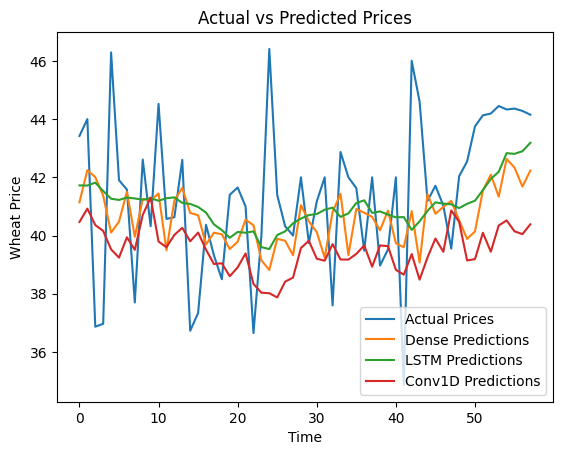

In [26]:
time_points = np.arange(0, len(y_test))

plt.plot(time_points, idk, label='Actual Prices')
plt.plot(time_points, idk1, label='Dense Predictions')
plt.plot(time_points, idk2, label='LSTM Predictions')
plt.plot(time_points, idk3, label='Conv1D Predictions')

plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Wheat Price')
plt.legend()
plt.show()
